In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def show(path):
    img_arr = np.array(Image.open(path))
    plt.imshow(img_arr)
    plt.axis('off')
    plt.show()

In [2]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms

class UnderWaterImages(Dataset):
    def __init__(self,folder,transforms=None):
        self.raw = os.path.join(folder,'Raw')
        self.ref = os.path.join(folder,'Reference')
        self.image_names = os.listdir(self.raw)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_names)
        
    def __getitem__(self,idx):
        img_name = self.image_names[idx]
        raw_path = os.path.join(self.raw,img_name)
        ref_path = os.path.join(self.ref,img_name)
        raw_img = Image.open(raw_path).convert('RGB')
        ref_img = Image.open(ref_path).convert('RGB')

        if self.transforms:
            raw_img = self.transforms(raw_img)
            ref_img = self.transforms(ref_img)
        return raw_img,ref_img

In [3]:
transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

In [4]:
train_dataset = UnderWaterImages('/kaggle/input/denoisingunderwaterimages/Train',transforms)

In [42]:
from torch.utils.data import random_split, DataLoader
test_dataset = UnderWaterImages('/kaggle/input/denoisingunderwaterimages/Test',transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
from torch.utils.data import random_split, DataLoader
dataset_size = len(train_dataset)
val_size = int(0.2 * dataset_size)   
train_size = dataset_size - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,3,stride=stride,padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Identity()
        if in_channels!=out_channels or stride!=1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,1,stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
    def forward(self,x):
        identity = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + identity
        out = F.relu(out)
        return out 

In [7]:
from torch import optim
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
log_interval = 10

In [24]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        ##decoder
        self.conv1 = nn.Conv2d(3,16,7,stride=2,padding=3)
        
        #each residual block halfs the dimension
        self.res1 = ResidualBlock(16,32,2) 
        self.res2 = ResidualBlock(32,64,2)
        self.res3 = ResidualBlock(64,128,2)
        self.res4 = ResidualBlock(128,256,2)
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc_mean = nn.Linear(256,128)
        self.fc_var = nn.Linear(256,128)
        # self.fc_mean = nn.Linear(128,64)
        # self.fc_var = nn.Linear(128,64)        

        ##encoder
        self.fc1 = nn.Linear(128,256*7*7)

        #kernel=4 stride=2 padding=1 always doubles the dim
        self.up1 = nn.ConvTranspose2d(256,128,4,stride=2,padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.up2 = nn.ConvTranspose2d(128,64,4,stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.up3 = nn.ConvTranspose2d(64,32,4,stride=2,padding=1)   
        self.bn3 = nn.BatchNorm2d(32)
        self.up4 = nn.ConvTranspose2d(32,16,4,stride=2,padding=1)  
        self.bn4 = nn.BatchNorm2d(16)
        self.up5 = nn.ConvTranspose2d(16,3,4,stride=2,padding=1)      

        
    def encode(self,x):
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = torch.flatten(self.avgpool(x),1)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean,log_var

    def reparameterize(self,mu,log_var):
        std = torch.exp(0.5*log_var) #0.5 prevents very huge value 
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z

    def decode(self,z):
        out = F.relu(self.fc1(z))
        out = out.view(-1,256,7,7)
        out = F.relu(self.bn1(self.up1(out)))
        out = F.relu(self.bn2(self.up2(out)))
        out = F.relu(self.bn3(self.up3(out)))
        out = F.relu(self.bn4(self.up4(out)))
        out = torch.sigmoid(self.up5(out))
        return out

    def loss_function(self,out,ref,mu,log_vars,beta=0.5):
        loss = nn.MSELoss(reduction='mean')
        recon_loss = loss(ref,out)*(ref.shape[1] * ref.shape[2] * ref.shape[3])
        
        kld = -0.5 * torch.sum(1 + log_vars - mu.pow(2) - log_vars.exp())

        return recon_loss+(kld*beta)

    def forward(self,x):
        mu,log_vars = self.encode(x)
        z = self.reparameterize(mu,log_vars)
        out = self.decode(z)

        return out,mu,log_vars

In [17]:
from torch import optim
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else 'cpu'
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
log_interval = 10

In [13]:
def train(epoch):
    model.train() #what this does
    train_loss = 0
    for batch_idx, (raw,ref) in enumerate(train_loader):
        raw = raw.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(raw)
        loss = model.loss_function(recon_batch, ref.to(device), mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(raw), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(raw)))


    print('Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [37]:
import torch
import os
import matplotlib.pyplot as plt

save_epochs = [int(frac * epochs) for frac in [0.25, 0.5, 0.75, 1.0]]
fixed_raw, fixed_ref = next(iter(val_loader))
fixed_raw, fixed_ref = fixed_raw.to(device), fixed_ref.to(device)

os.makedirs("results", exist_ok=True)

def save_reconstruction(model, data, ref, epoch, step_fraction):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data)
    recon = recon[0].cpu()
    data = data[0].cpu()
    ref = ref[0].cpu()
    
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(data.permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title("Noisy")
    axes[0].axis("off")
    axes[1].imshow(recon.permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")
    axes[2].imshow(ref.permute(1, 2, 0).clamp(0, 1))
    axes[2].set_title("Reference")
    axes[2].axis("off")    

    plt.tight_layout()
    plt.savefig(f"results/epoch{epoch}_step{step_fraction}.png")
    plt.close()


epochs = 100
best_val_loss = float('inf')
patience = 10 
patience_counter = 0

for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch in save_epochs:
        save_reconstruction(model, fixed_raw, fixed_ref, epoch, int(epoch / epochs * 100))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, target.to(device), mu, logvar)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch: {epoch} Average validation loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print('Validation loss decreased. Saving model.')
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print('Early stopping triggered!')
        break


Train Epoch: 1 [0/560 (0%)]	Loss: 365.770691
Train Epoch: 1 [320/560 (56%)]	Loss: 302.111450
Epoch: 1 Average loss: 316.1182
Epoch: 1 Average validation loss: 315.6682
Validation loss decreased. Saving model.
Train Epoch: 2 [0/560 (0%)]	Loss: 273.067474
Train Epoch: 2 [320/560 (56%)]	Loss: 260.810974
Epoch: 2 Average loss: 288.8079
Epoch: 2 Average validation loss: 307.4007
Validation loss decreased. Saving model.
Train Epoch: 3 [0/560 (0%)]	Loss: 254.238235
Train Epoch: 3 [320/560 (56%)]	Loss: 290.706268
Epoch: 3 Average loss: 278.7818
Epoch: 3 Average validation loss: 440.3313
Validation loss did not improve. Patience: 1/10
Train Epoch: 4 [0/560 (0%)]	Loss: 270.168182
Train Epoch: 4 [320/560 (56%)]	Loss: 262.929779
Epoch: 4 Average loss: 268.1052
Epoch: 4 Average validation loss: 364.4659
Validation loss did not improve. Patience: 2/10
Train Epoch: 5 [0/560 (0%)]	Loss: 271.267212
Train Epoch: 5 [320/560 (56%)]	Loss: 249.423843
Epoch: 5 Average loss: 259.5056
Epoch: 5 Average validati

In [39]:
fixed_raw, fixed_ref = next(iter(train_loader))
fixed_raw, fixed_ref = fixed_raw.to(device), fixed_ref.to(device)
save_reconstruction(model, fixed_raw, fixed_ref, 100,0)

**Problems:** 
- The reconstruction is not really good. Maybe the adapative avg pool is squashing the information too much
- The MSE loss is penalising too much. The model tries to avoid this by producing an average output at of the pixel leading to blurring

**Experiment:** 
- Trying to remove average pool and only flatten.
- Use L1 loss instead of L2

In [18]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        ##decoder
        self.conv1 = nn.Conv2d(3,16,7,stride=2,padding=3)
        
        #each residual block halfs the dimension
        self.res1 = ResidualBlock(16,32,2) 
        self.res2 = ResidualBlock(32,64,2)
        self.res3 = ResidualBlock(64,128,2)
        self.res4 = ResidualBlock(128,256,2)
        # self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc_mean = nn.Linear(256*7*7,128)
        self.fc_var = nn.Linear(256*7*7,128)
        # self.fc_mean = nn.Linear(128,64)
        # self.fc_var = nn.Linear(128,64)        

        ##encoder
        self.fc1 = nn.Linear(128,256*7*7)

        #kernel=4 stride=2 padding=1 always doubles the dim
        self.up1 = nn.ConvTranspose2d(256,128,4,stride=2,padding=1)
        self.bn1 = nn.BatchNorm2d(128)
        self.up2 = nn.ConvTranspose2d(128,64,4,stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.up3 = nn.ConvTranspose2d(64,32,4,stride=2,padding=1)   
        self.bn3 = nn.BatchNorm2d(32)
        self.up4 = nn.ConvTranspose2d(32,16,4,stride=2,padding=1)  
        self.bn4 = nn.BatchNorm2d(16)
        self.up5 = nn.ConvTranspose2d(16,3,4,stride=2,padding=1)      

        
    def encode(self,x):
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        x = self.res4(x)
        x = torch.flatten(x,1)
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)
        return mean,log_var

    def reparameterize(self,mu,log_var):
        std = torch.exp(0.5*log_var) #0.5 prevents very huge value 
        eps = torch.randn_like(std)
        z = mu + std*eps
        return z

    def decode(self,z):
        out = F.relu(self.fc1(z))
        out = out.view(-1,256,7,7)
        out = F.relu(self.bn1(self.up1(out)))
        out = F.relu(self.bn2(self.up2(out)))
        out = F.relu(self.bn3(self.up3(out)))
        out = F.relu(self.bn4(self.up4(out)))
        out = torch.sigmoid(self.up5(out))
        return out

    def loss_function(self,out,x,mu,log_vars,beta=0.5):
        loss = nn.L1Loss(reduction='mean')
        recon_loss = loss(x,out)*(x.shape[1] * x.shape[2] * x.shape[3])
        
        kld = -0.5 * torch.sum(1 + log_vars - mu.pow(2) - log_vars.exp())

        return recon_loss+(kld*beta)

    def forward(self,x):
        mu,log_vars = self.encode(x)
        z = self.reparameterize(mu,log_vars)
        out = self.decode(z)

        return out,mu,log_vars

In [19]:
import torch
import os
import matplotlib.pyplot as plt

epochs = 100
best_val_loss = float('inf')
patience = 10 
patience_counter = 0

save_epochs = [int(frac * epochs) for frac in [0.25, 0.5, 0.75, 1.0]]
fixed_raw, fixed_ref = next(iter(val_loader))
fixed_raw, fixed_ref = fixed_raw.to(device), fixed_ref.to(device)

os.makedirs("results", exist_ok=True)

def save_reconstruction(model, data, ref, epoch, step_fraction):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data)
    recon = recon[0].cpu()
    data = data[0].cpu()
    ref = ref[0].cpu()
    
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(data.permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title("Noisy")
    axes[0].axis("off")
    axes[1].imshow(recon.permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")
    axes[2].imshow(ref.permute(1, 2, 0).clamp(0, 1))
    axes[2].set_title("Reference")
    axes[2].axis("off")    

    plt.tight_layout()
    plt.savefig(f"results/epoch{epoch}_step{step_fraction}.png")
    plt.close()

for epoch in range(1, epochs + 1):
    train(epoch)
    if epoch in save_epochs:
        save_reconstruction(model, fixed_raw, fixed_ref, epoch, int(epoch / epochs * 100))

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = model.loss_function(recon_batch, target.to(device), mu, logvar)
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f'Epoch: {epoch} Average validation loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print('Validation loss decreased. Saving model.')
    else:
        patience_counter += 1
        print(f'Validation loss did not improve. Patience: {patience_counter}/{patience}')

    if patience_counter >= patience:
        print('Early stopping triggered!')
        break


Train Epoch: 1 [0/560 (0%)]	Loss: 1129.443726
Train Epoch: 1 [320/560 (56%)]	Loss: 1310.017700
Epoch: 1 Average loss: 1723.4250
Epoch: 1 Average validation loss: 1161.8601
Validation loss decreased. Saving model.
Train Epoch: 2 [0/560 (0%)]	Loss: 1164.801147
Train Epoch: 2 [320/560 (56%)]	Loss: 1063.684570
Epoch: 2 Average loss: 1118.3010
Epoch: 2 Average validation loss: 1119.7463
Validation loss decreased. Saving model.
Train Epoch: 3 [0/560 (0%)]	Loss: 1069.814697
Train Epoch: 3 [320/560 (56%)]	Loss: 988.969299
Epoch: 3 Average loss: 1018.1618
Epoch: 3 Average validation loss: 1076.6768
Validation loss decreased. Saving model.
Train Epoch: 4 [0/560 (0%)]	Loss: 954.208191
Train Epoch: 4 [320/560 (56%)]	Loss: 1048.949707
Epoch: 4 Average loss: 964.6976
Epoch: 4 Average validation loss: 1152.0280
Validation loss did not improve. Patience: 1/10
Train Epoch: 5 [0/560 (0%)]	Loss: 900.235657
Train Epoch: 5 [320/560 (56%)]	Loss: 902.412354
Epoch: 5 Average loss: 938.2423
Epoch: 5 Average va

In [ ]:
def save_reconstruction(model, data, ref, epoch, step_fraction):
    model.eval()
    with torch.no_grad():
        recon, _, _ = model(data)
    recon = recon[0].cpu()
    data = data[0].cpu()
    ref = ref[0].cpu()
    
    fig, axes = plt.subplots(1, 3, figsize=(6, 3))
    axes[0].imshow(data.permute(1, 2, 0).clamp(0, 1))
    axes[0].set_title("Noisy")
    axes[0].axis("off")
    axes[1].imshow(recon.permute(1, 2, 0).clamp(0, 1))
    axes[1].set_title("Reconstructed")
    axes[1].axis("off")
    axes[2].imshow(ref.permute(1, 2, 0).clamp(0, 1))
    axes[2].set_title("Reference")
    axes[2].axis("off")    

    plt.tight_layout()
    plt.savefig(f"results/epoch{epoch}_step{step_fraction}.png")
    plt.close()


In [44]:
def display_results(loader):
    fig,axes = plt.subplots(3,3,figsize=(10,5))
    for i,(batch_raw,batch_ref) in enumerate(loader):
        if i>=3: break
           
        model.eval()
        batch_raw, batch_ref = batch_raw.to(device), batch_ref.to(device)
        batch_recon,_,_ = model(batch_raw)
        
        recon = batch_recon[0].detach().cpu()
        raw = batch_raw[0].detach().cpu()
        ref = batch_ref[0].detach().cpu()
            
        axes[i][0].imshow(raw.permute(1,2,0).clamp(0,1))
        axes[i][0].set_title("Noisy")
        axes[i][0].axis("off")
        axes[i][1].imshow(recon.permute(1,2,0).clamp(0,1))
        axes[i][1].set_title("Reconstructed")
        axes[i][1].axis("off")
        axes[i][2].imshow(ref.permute(1,2,0).clamp(0,1))
        axes[i][2].set_title("Clean image")
        axes[i][2].axis("off")
    
 

    plt.tight_layout()
    plt.savefig(f"results.png")
    plt.show()

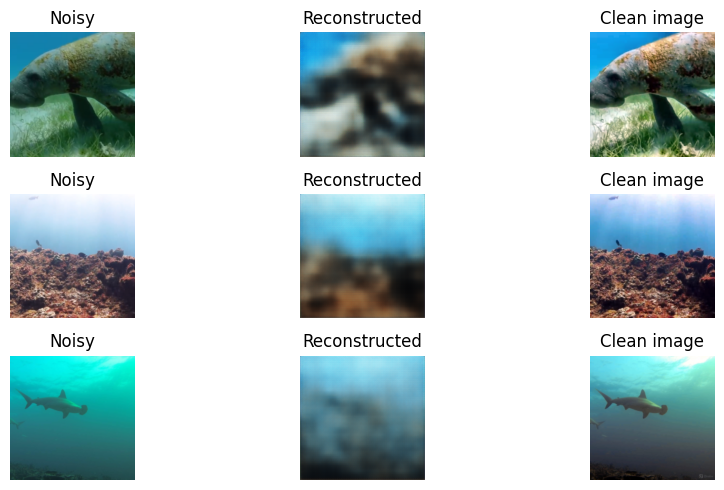

In [45]:
display_results(train_loader)

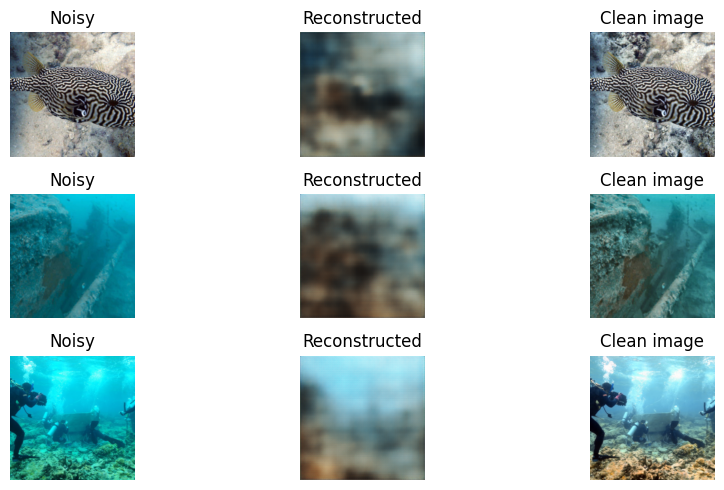

In [47]:
display_results(val_loader)

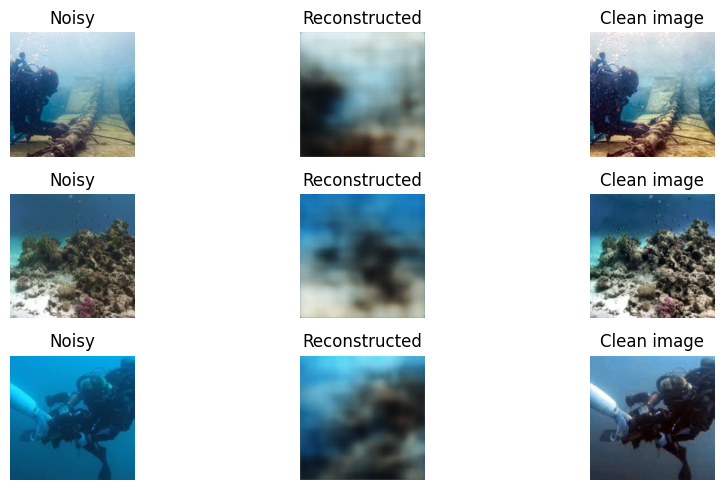

In [46]:
display_results(test_loader)

**Results**

In [ ]:
import torch
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error

def compute_metrics_batch(original_batch, reconstructed_batch):
    batch_size = original_batch.size(0)
    original_batch = original_batch.detach().cpu().permute(0,2,3,1).numpy().astype(np.float32)
    reconstructed_batch = reconstructed_batch.detach().cpu().permute(0,2,3,1).numpy().astype(np.float32)

    mse_list = []
    psnr_list = []
    ssim_list = []

    for i in range(batch_size):
        orig = original_batch[i]
        recon = reconstructed_batch[i]

        mse_list.append(mean_squared_error(orig, recon))
        psnr_list.append(peak_signal_noise_ratio(orig, recon, data_range=1))
        ssim_list.append(structural_similarity(orig, recon, channel_axis=-1, data_range=1))

    mse_avg = np.mean(mse_list)
    psnr_avg = np.mean(psnr_list)
    ssim_avg = np.mean(ssim_list)

    return mse_avg, psnr_avg, ssim_avg

In [ ]:
mse_total = 0.0
psnr_total = 0.0
ssim_total = 0.0
num_batches = 0

model.eval()
with torch.no_grad():
    for (raw,ref) in test_loader:
        raw = raw.to(device)
        ref = ref.to(device)
        recon_batch, mu, logvar = model(raw)

        mse, psnr, ssim = compute_metrics_batch(ref, recon_batch)

        mse_total += mse
        psnr_total += psnr
        ssim_total += ssim
        num_batches += 1

mse_avg = mse_total / num_batches
psnr_avg = psnr_total / num_batches
ssim_avg = ssim_total / num_batches

print(f"Test MSE: {mse_avg:.4f}")
print(f"Test PSNR: {psnr_avg:.2f} dB")
print(f"Test SSIM: {ssim_avg:.4f}")